In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from natsort import natsorted, ns
import scipy.io
import cv2
import dlib
from PIL import Image

## Useful Functions

In [3]:
def resize_image(image, new_size=(128, 128)):
    """resize a numpy image using PIL image with antialiasing"""
    img_resize = Image.fromarray(image)
    img_resize = img_resize.resize(new_size, Image.ANTIALIAS)
    img_resize_np = np.array(img_resize)
    return img_resize_np

In [4]:
def resize_image_list(image_list, new_size=(128, 128)):
    """resize a list of rgb images"""
    new_image_list = []
    for i, img in enumerate(image_list):
        new_image = resize_image(img, new_size=new_size)
        new_image_list.append(new_image)
    return new_image_list 

In [5]:
def optimal_quantization(t2d_data, print_mode = False):
    """scale values in thermal image to cover most suitable range"""
    t2d_data_cp = copy.deepcopy(t2d_data)  
    
    vector_data= np.reshape(t2d_data_cp, t2d_data_cp.shape[0]*t2d_data_cp.shape[1])
    # select only values above zero when calculating min/max to avoid padding - sm
    vector_data = vector_data[vector_data > 0]
    
    min_T=np.percentile(vector_data, 2.5)  #2.5 percentile point
#     max_T=np.percentile(vector_data, 97.5) #97.5 percentile point
    
    # try a higher max_T - sm
    max_T=np.percentile(vector_data, 100) #99.5 percentile point
#     max_T = 36

    t2d_data_cp[np.where(t2d_data_cp > max_T)]=max_T
    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    opt_T=min_T
    count=0
    while True:
        count+=1
        mean_back=np.mean(t2d_data_cp[np.where(t2d_data_cp <= opt_T)])
        mean_obj=np.mean(t2d_data_cp[np.where(t2d_data_cp > opt_T)])
        if np.abs(opt_T - (mean_back+mean_obj)/2 )<0.005:
            break;
        else:
            opt_T=(mean_back+mean_obj)/2

    min_T=opt_T

    if print_mode:
        print("optimal thermal range is [%f, %f]"%(min_T,max_T))

    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    quantized_t_img=np.zeros((t2d_data_cp.shape[0],t2d_data_cp.shape[1]), np.uint8)

    for i in range(0, t2d_data_cp.shape[0]):
        for j in range(0, t2d_data_cp.shape[1]):
            quantized_t_img[i,j]=255*((t2d_data_cp[i,j]-min_T)/(max_T-min_T))

    return quantized_t_img 

In [6]:
def opt_quant_list(image_list, print_mode=False):
    """Optimal quantization of a list of rgb images"""
    new_image_list = []
    for i, img in enumerate(image_list):
        new_image = optimal_quantization(img, print_mode = print_mode)
        new_image_list.append(new_image)
    return new_image_list 

In [7]:
def thr_load(img_dir, first_img=0, last_img=None, interval=1):
    """load a range of thermal files"""
    # create list of jpg images in directory
    filenames = [f for f in os.listdir(img_dir) if f.split('.')[1] == 'npy']
    # sort filenames
    filenames = natsorted(filenames, alg=ns.IGNORECASE)
        
    img_list = []
        
    # selecting images to analyse
    filenames=filenames[first_img:last_img:interval]
        
    for filename in filenames:
        img = np.load(img_dir + filename)
        img_list.append(img)
        
    return filenames, img_list

In [8]:
def rgb_load(img_dir, first_img=0, last_img=None, interval=1):
    """load a range of rgb files"""
    # create list of jpg images in directory
    filenames = [f for f in os.listdir(img_dir) if f.split('.')[1] == 'jpg']
    filenames.sort()
    
    img_list = []
    
    # selecting images to analyse
    filenames=filenames[first_img:last_img:interval]
    
    for filename in filenames:
        img = dlib.load_rgb_image(img_dir + filename)
        img_list.append(img)
        
    return filenames, img_list

In [9]:
def compare_plot(rgb_img_list, thr_img_list, rgb_img_no, thr_img_no):
    """compare plots from lists of thermal and rgb images"""
    fig, ax = plt.subplots(ncols=2, figsize=(16, 12))
    ax[0].imshow(thr_img_list[thr_img_no], cmap=plt.get_cmap('hot'))
    ax[1].imshow(rgb_img_list[rgb_img_no])
#     ax[0].grid()
#     ax[1].grid()
    plt.show()

In [10]:
def output_thr_jpg_list(img_list, filename_list, save_dir):
    """ output list of jpg images"""
    for i, img in enumerate(img_list):
        fname = filename_list[i].split('.')[0]
        save_path = save_dir + fname + '_proc.jpg'
        im = Image.fromarray(img)
        im = im.convert("L")
        im.save(save_path)

In [11]:
def output_rgb_npy_list(img_list, filename_list, save_dir):
    for i, img in enumerate(img_list):
        fname = filename_list[i].split('.')[0]
        save_path = save_dir + fname + '.npy'
        np.save(save_path, img)

In [12]:
def synced_outputs(p, 
                   rgb_first_img, rgb_last_img, rgb_int, 
                   thr_first_img, thr_last_img, thr_int,
                   noresize=False,
                   resize43=False,
                   resize169=True):
    
    # load selected rgb data
    rgb_img_dir = '/Volumes/Ashur DT2/steven/P'+p+'/RGB/00000/'
    rgb_fname_list, rgb_img_list = rgb_load(img_dir=rgb_img_dir,
                                        first_img=rgb_first_img, 
                                        last_img=rgb_last_img, 
                                        interval=rgb_int)
    
    # load selected thr data
    thr_img_dir = '/Volumes/Ashur DT2/steven/P'+p+'/FLIR_HiRes/npy/'
    thr_fname_list, thr_img_list = thr_load(img_dir=thr_img_dir, 
                                        first_img=thr_first_img, 
                                        last_img=thr_last_img, 
                                        interval=thr_int)
    
    # optimal quantization thermal
    thr_img_oq_list = opt_quant_list(thr_img_list)
    
    # export all thr frames
    save_dir = '/Volumes/Ashur DT2/steven/P'+p+'/FLIR_HiRes/jpg/'
    # make output directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    output_thr_jpg_list(thr_img_oq_list, thr_fname_list, save_dir)

    # export selected thr frames
    thr_img_oq_list_i30 = [thr_img_oq_list[i] for i in range(0,len(thr_img_oq_list), 30)]
    thr_fname_list_i30 = [thr_fname_list[i] for i in range(0,len(thr_fname_list), 30)]
        
    save_dir = '/Volumes/Ashur DT2/steven/P'+p+'/FLIR_HiRes/jpg_sel/'
    # make output directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    output_thr_jpg_list(thr_img_oq_list_i30, thr_fname_list_i30, save_dir)
    
    if noresize==True:
        # export rgb frames without resizing
        save_dir = '/Volumes/Ashur DT2/steven/P'+p+'/RGB/00000_npy_noresize/'
        # make output directory if it does not exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        output_rgb_npy_list(rgb_img_list, rgb_fname_list, save_dir)
        
    if resize43==True:
        # export rgb frames with 4:3 aspect resizing
        rgb_img_resize43_list = resize_image_list(rgb_img_list, new_size=(341,256))
        save_dir = '/Volumes/Ashur DT2/steven/P'+p+'/RGB/00000_npy_43/'
        # make output directory if it does not exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        output_rgb_npy_list(rgb_img_resize43_list, rgb_fname_list, save_dir)
        
    if resize169==True:
        # export rgb frames with 16:9 aspect resizing
        rgb_img_resize169_list = resize_image_list(rgb_img_list, new_size=(455,256))
        save_dir = '/Volumes/Ashur DT2/steven/P'+p+'/RGB/00000_npy_169/'
        # make output directory if it does not exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        output_rgb_npy_list(rgb_img_resize169_list, rgb_fname_list, save_dir)

        # compare frames that should be synched
        compare_plot(rgb_img_resize169_list, thr_img_oq_list, rgb_img_no=250, thr_img_no=300)        

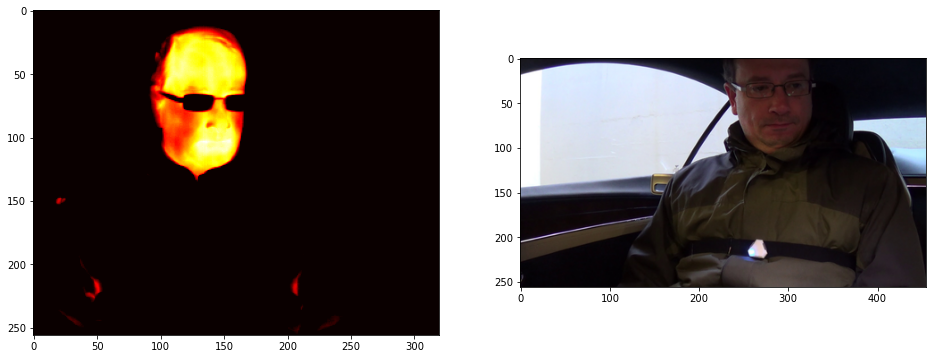

runtime: 126.08074116706848


In [18]:
p = '03'

rgb_first_img = 175
rgb_last_img = 675
rgb_int = 1

thr_first_img = 1482
thr_last_img = 2082
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

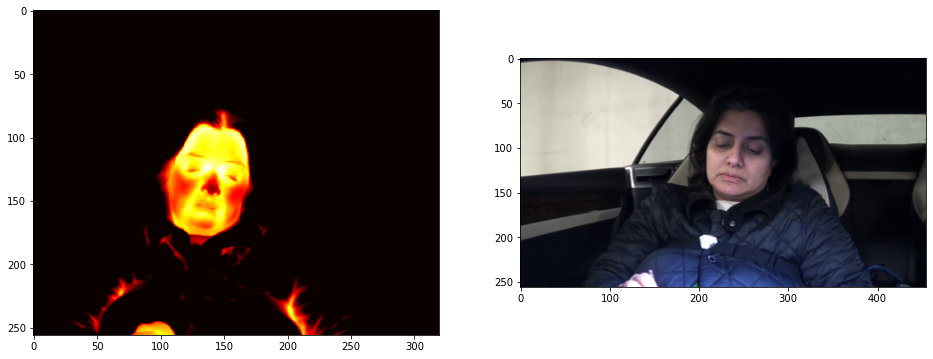

runtime: 191.25148606300354


In [17]:
p = '04'

rgb_first_img = 11340
rgb_last_img = 11840
rgb_int = 1

thr_first_img = 12758
thr_last_img = 13358
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

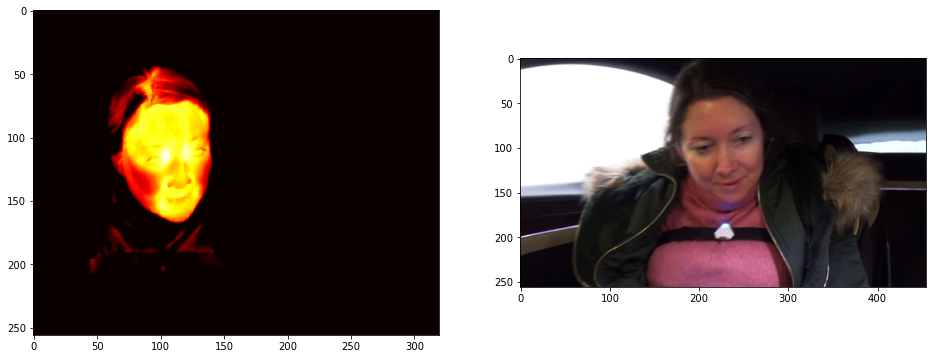

runtime: 129.70448780059814


In [16]:
p = '05'

rgb_first_img = 14173
rgb_last_img = 14673
rgb_int = 1

thr_first_img = 16067
thr_last_img = 16667
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

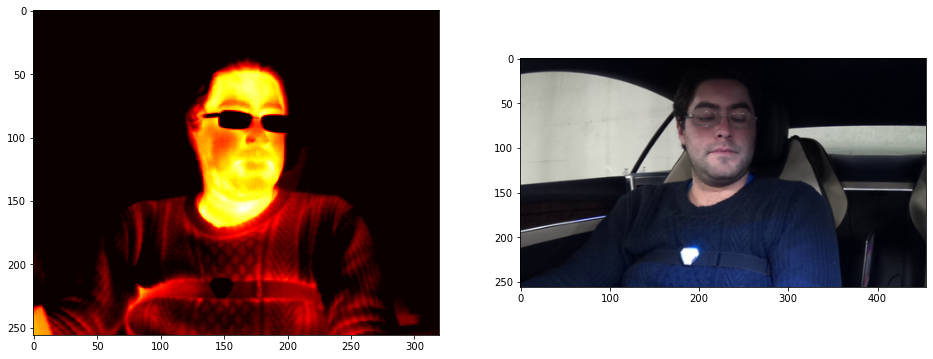

runtime: 124.16308617591858


In [15]:
p = '07'

rgb_first_img = 10826
rgb_last_img = 11326
rgb_int = 1

thr_first_img = 12179
thr_last_img = 12779
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

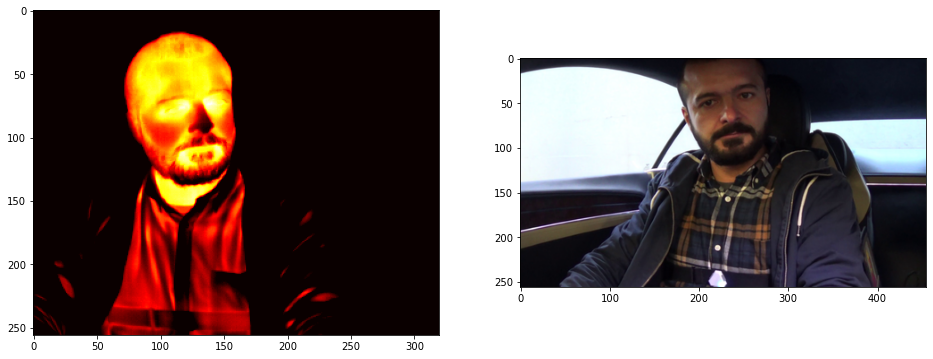

runtime: 112.49176502227783


In [14]:
p = '08'

rgb_first_img = 13008
rgb_last_img = 13508
rgb_int = 1

thr_first_img = 13098
thr_last_img = 13698
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

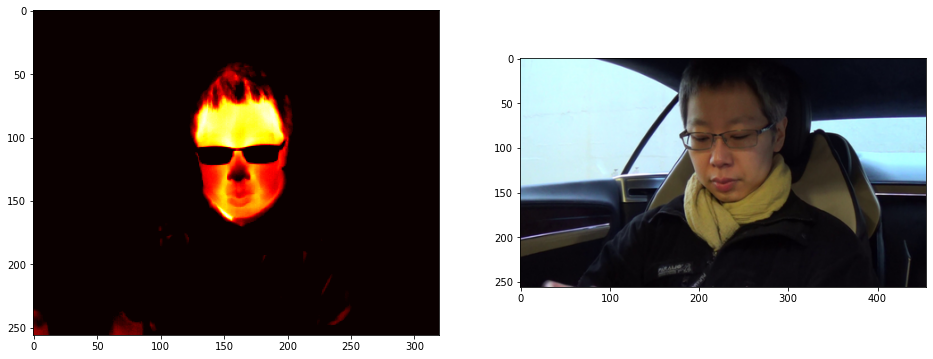

runtime: 124.53862500190735


In [13]:
p = '09'

rgb_first_img = 13071
rgb_last_img = 13571
rgb_int = 1

thr_first_img = 14876
thr_last_img = 15476
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

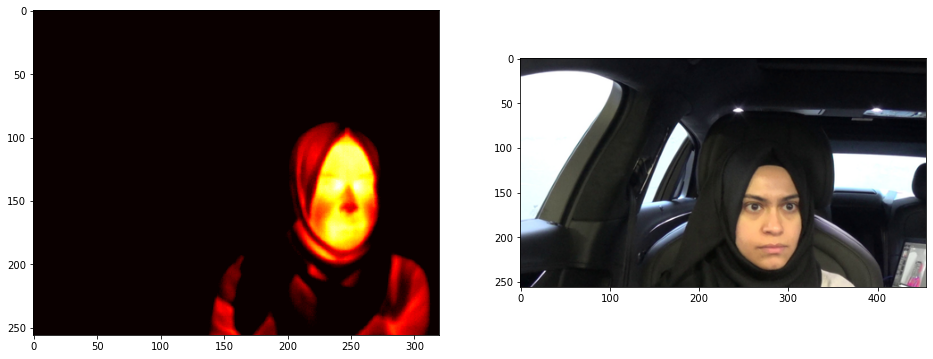

runtime: 127.53398489952087


In [17]:
p = '10'

rgb_first_img = 15678
rgb_last_img = 16178
rgb_int = 1

thr_first_img = 16901
thr_last_img = 17501
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

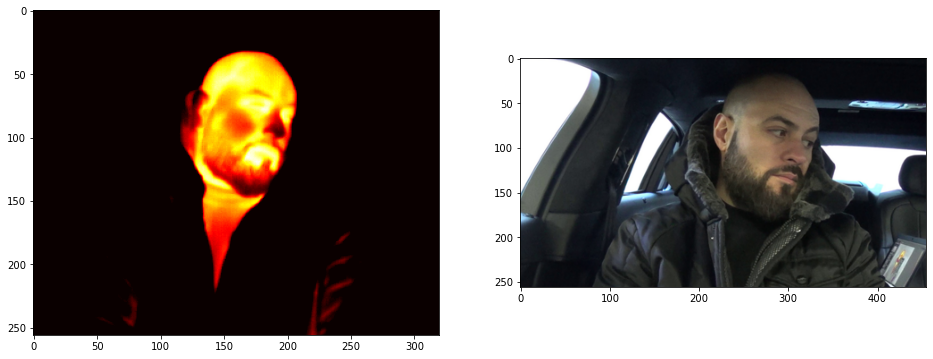

runtime: 104.32767105102539


In [14]:
p = '13'

rgb_first_img = 2743
rgb_last_img = 3243
rgb_int = 1

thr_first_img = 2063
thr_last_img = 2663
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

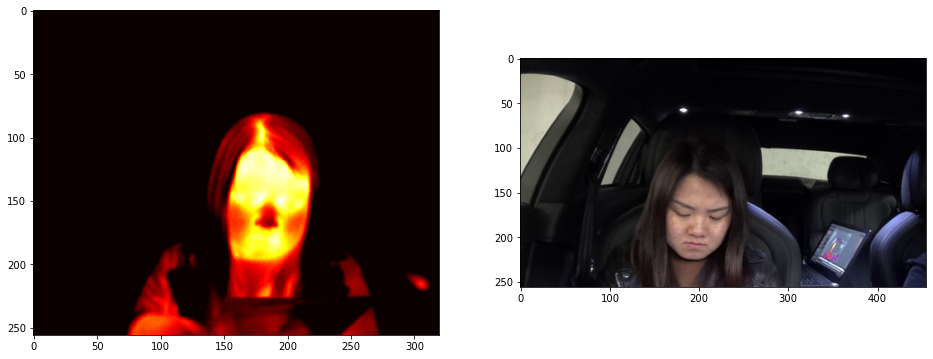

runtime: 117.01416015625


In [15]:
p = '14'

rgb_first_img = 18226
rgb_last_img = 18726
rgb_int = 1

thr_first_img = 20441
thr_last_img = 21041
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

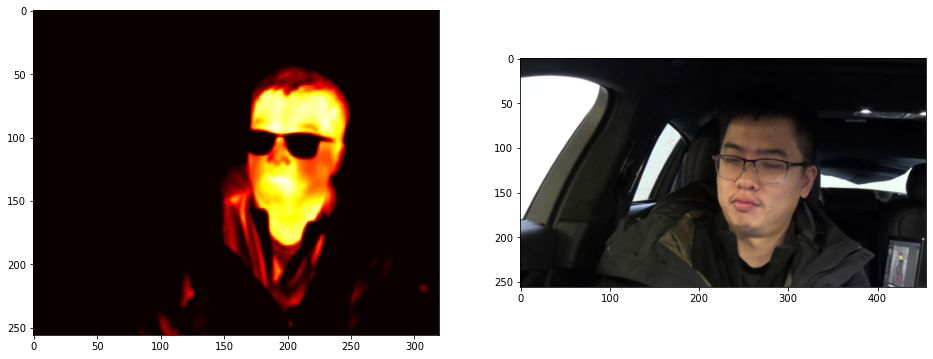

runtime: 103.96616697311401


In [16]:
p = '15'

rgb_first_img = 6950
rgb_last_img = 7450
rgb_int = 1

thr_first_img = 4051
thr_last_img = 4651
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

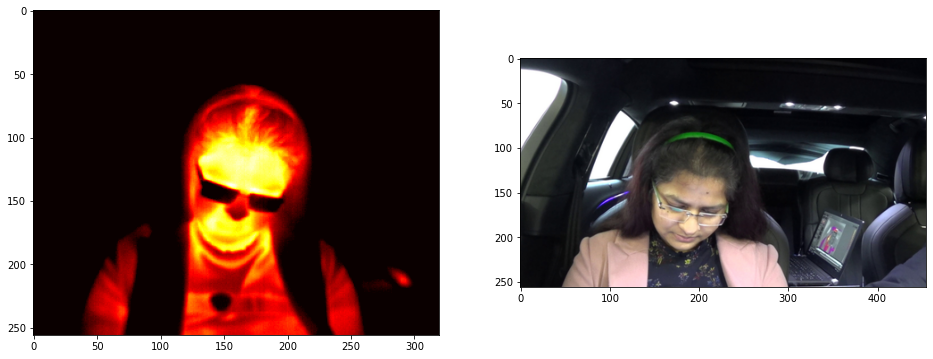

runtime: 117.73167586326599


In [17]:
p = '16'

rgb_first_img = 3403
rgb_last_img = 3903
rgb_int = 1

thr_first_img = 3418
thr_last_img = 4018
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

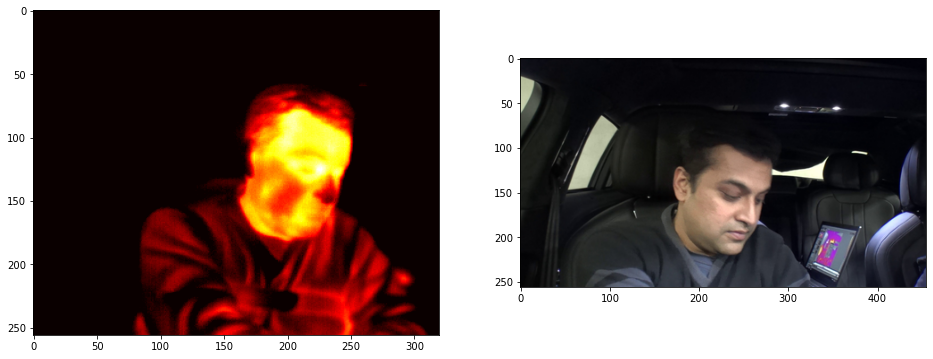

runtime: 111.03699398040771


In [20]:
p = '17'

rgb_first_img = 2661
rgb_last_img = 3161
rgb_int = 1

thr_first_img = 2355
thr_last_img = 2955
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

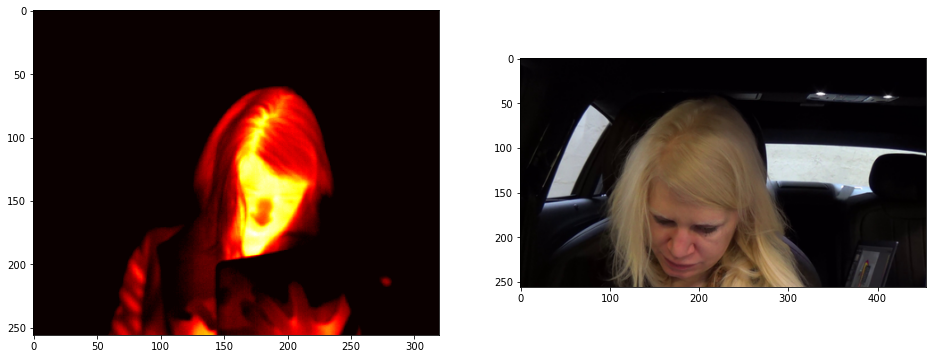

runtime: 112.28293180465698


In [18]:
p = '18'

rgb_first_img = 8145
rgb_last_img = 8645
rgb_int = 1

thr_first_img = 16500
thr_last_img = 17100
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

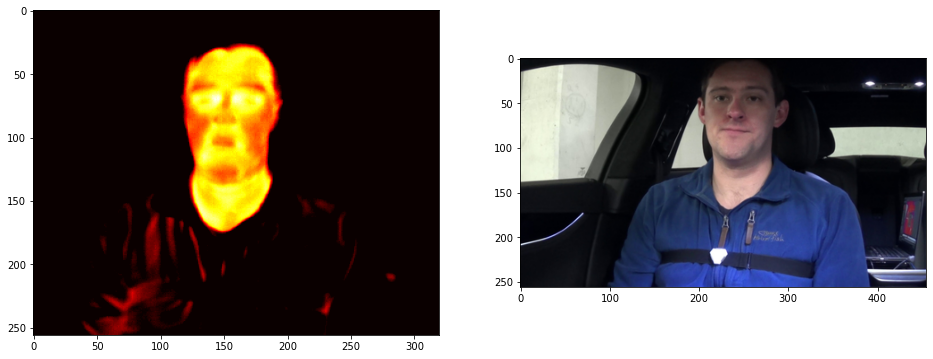

runtime: 138.57355785369873


In [19]:
p = '19'

rgb_first_img = 2137
rgb_last_img = 2637
rgb_int = 1

thr_first_img = 2770
thr_last_img = 3370
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

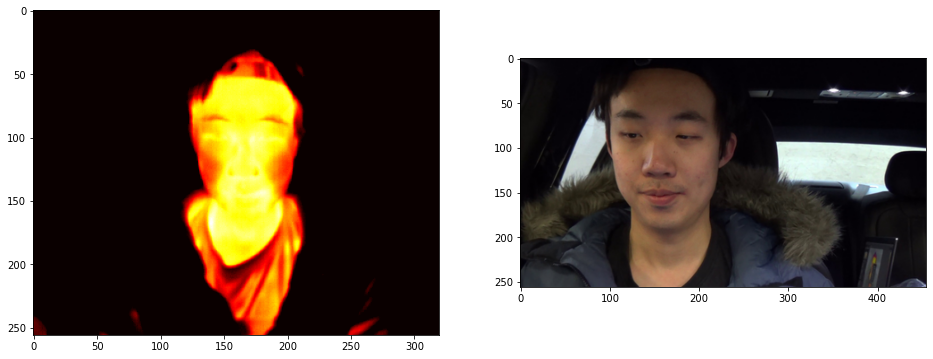

runtime: 119.04176592826843


In [20]:
p = '20'

rgb_first_img = 6847
rgb_last_img = 7347
rgb_int = 1

thr_first_img = 13680
thr_last_img = 14280
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

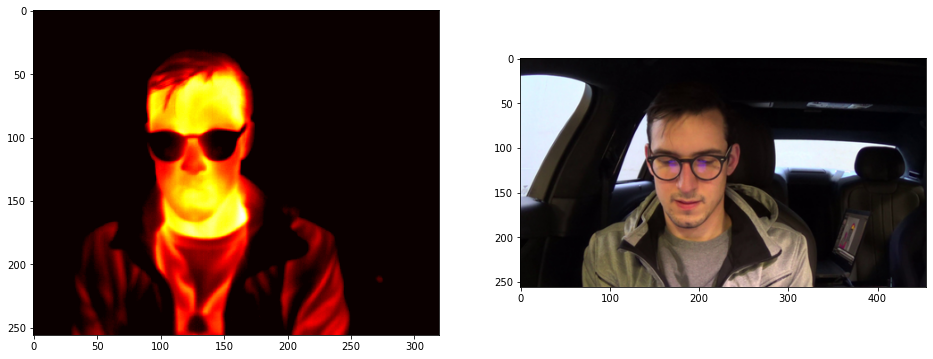

runtime: 109.70341205596924


In [21]:
p = '22'

rgb_first_img = 7371
rgb_last_img = 7871
rgb_int = 1

thr_first_img = 7548
thr_last_img = 8148
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

In [ ]:
p = '24'

rgb_first_img = 9442
rgb_last_img = 9942
rgb_int = 1

thr_first_img = 10086
thr_last_img = 10686
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

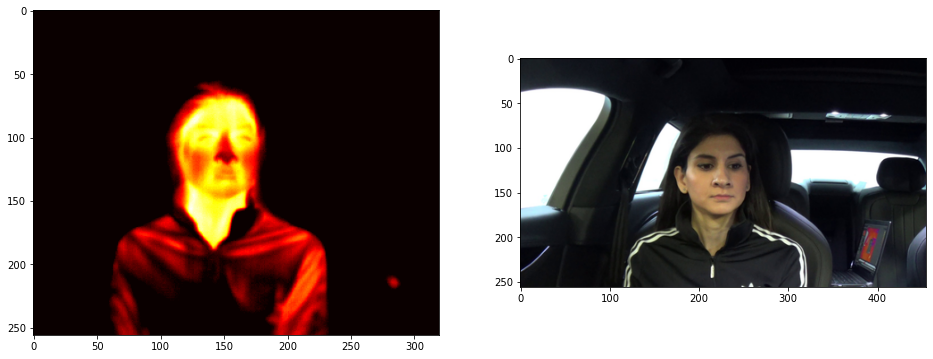

runtime: 173.8407597541809


In [13]:
p = '25'

rgb_first_img = 754
rgb_last_img = 1254
rgb_int = 1

thr_first_img = 1819
thr_last_img = 2419
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

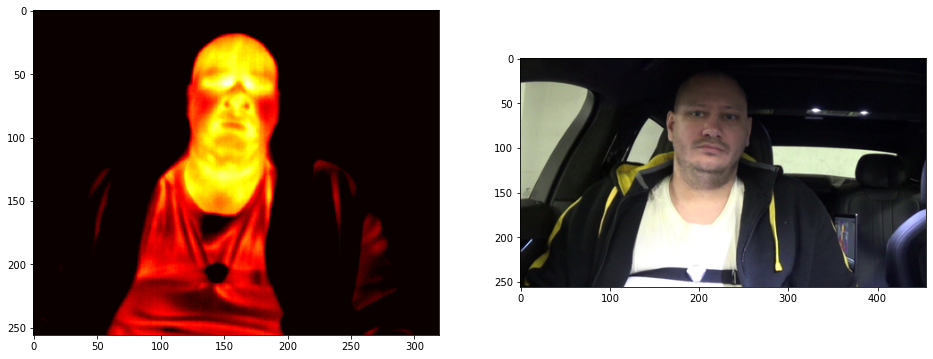

runtime: 142.71915531158447


In [14]:
p = '26'

rgb_first_img = 1050
rgb_last_img = 1550
rgb_int = 1

thr_first_img = 352
thr_last_img = 952
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)

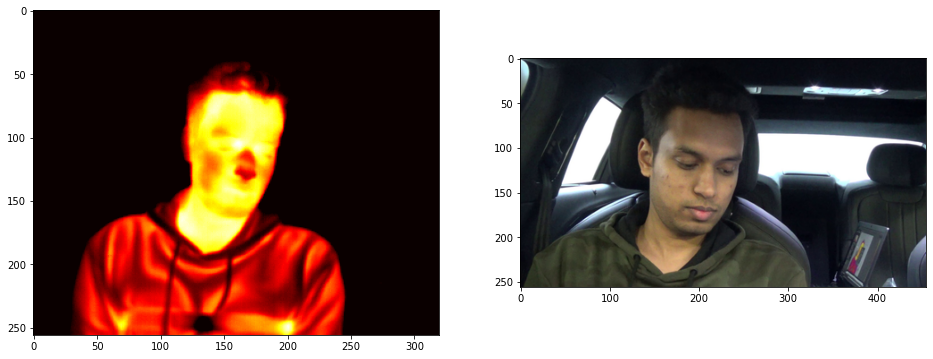

runtime: 90.47568011283875


In [15]:
p = '27'

rgb_first_img = 7996
rgb_last_img = 8496
rgb_int = 1

thr_first_img = 8767
thr_last_img = 9367
thr_int = 1

start_time = time.time()

synced_outputs(p, 
               rgb_first_img, rgb_last_img, rgb_int, 
               thr_first_img, thr_last_img, thr_int,
               noresize=False,
               resize43=False,
               resize169=True)

print("runtime:", time.time() - start_time)